<a href="https://colab.research.google.com/github/JuanArchidona/SeriesTemporales/blob/main/JAA_Juan_Archidona_Ahijado_final_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration

Import here the libraries you will need

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pystan~=2.14 fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import math
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pmdarima as pm
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, adfuller, pacf, kpss
from statsmodels.graphics.tsaplots import plot_acf 

import datetime as dt
from datetime import date, time
from dateutil import parser

from fbprophet import Prophet
from prophet.plot import add_changepoints_to_plot

Define the functions you will use later

In [ ]:
def plot_df(x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(10,3), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


def test_stationarity(timeseries, N):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=N).mean()
    rolstd = timeseries.rolling(window=N).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


def interpret_dftest(ts, th):
    # Dickey-Fuller test
    result_adf = adfuller(ts)

    print('ADF Statistic: %f' % result_adf[0])
    print('p-value: %f' % result_adf[1])
    print('Critical Values:')
    for key, value in result_adf[4].items():
	    print('\t%s: %.3f' % (key, value))
  
   # Result
    if result_adf[1] <= th and result_adf[0] <= list(result_adf[4].items())[1][1]: 
      print('We can reject the null hypothesis. Time series is stationary')
    else: print('Time series is not stationary')


def interpret_kpss(ts, th):
    # Dickey-kpss test
    result_kpss = kpss(ts)

    print('kpss Statistic: %f' % result_kpss[0])
    print('p-value: %f' % result_kpss[1])
    print('Truncation lag parameter: %f' % result_kpss[2])
    print('Critical Values:')
    for key, value in result_kpss[3].items():
	    print('\t%s: %.3f' % (key, value))
  
    if result_kpss[1] <= th and result_kpss[0] <= list(result_kpss[3].items())[1][1]: 
      print('We can reject the null hypothesis. Time series is stationary')
    else: print('Time series is not stationary')

    warnings.simplefilter('ignore')


def obtain_order_model(ts):
    # Obtain ACF and PCSF
    lag_acf = acf(ts, nlags=20, fft = True)
    lag_pacf = pacf(ts, nlags=20, method='ols')

    plt.figure(figsize=(8,4))
    #Plot ACF:    
    plt.subplot(121)    
    plt.plot(lag_acf, marker = '.')
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf, marker = '.')
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()


def obtain_order_model(ts):
    # Obtain ACF and PCSF
    lag_acf = acf(ts, nlags=20, fft = True)
    lag_pacf = pacf(ts, nlags=20, method='ols')

    plt.figure(figsize=(8,4))
    #Plot ACF:    
    plt.subplot(121)    
    plt.plot(lag_acf, marker = '.')
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf, marker = '.')
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()


def model_summary_results(model_fitted):
    # Model summary
    print(model_fitted.summary())
    
    # Model residuals
    residuals = pd.DataFrame(model_fitted.resid)
    residuals = residuals.reset_index()
    residuals = residuals.drop(['new_date'], axis=1)
    residuals.columns = ['residuals']

    # Plot
    plt.figure(figsize=(10,4))
    plt.subplot(121) 
    plt.plot(residuals)
    plt.title('Residuals')
    plt.subplot(122) 
    sns.kdeplot(data=residuals, x="residuals")
    plt.title('Density')
    plt.show()

def forecast_plot(data_test, data_train, fc_series): 
    plt.figure(figsize=(10, 4), dpi=100)
    plt.plot(data_train, label='Training')
    plt.plot(data_test, label='Actual')
    plt.plot(fc_series, label='Forecast')
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()


def forecasting(model_fitted, n_preds, data_test, title):
  # Predict
  forecast = model_fitted.forecast(n_preds, alpha=0.05)

  # Convert predictions to series
  fc_series = pd.Series(forecast, index=data_test.index)

  # Plot
  plt.figure(figsize=(10, 4), dpi=100)
  plt.plot(data_train.rain_all, label='Training')
  plt.plot(data_test.rain_all, label='Actual')
  plt.plot(fc_series, label='Forecast')
  plt.title(title)
  plt.legend(loc='upper left', fontsize=8)
  plt.show()


def forecast_accuracy(predicted, real):
    me = np.mean(predicted - real)                         # ME
    mae = np.mean(np.abs(predicted - real))                # MAE
    mape = np.mean(np.abs(predicted - real)/np.abs(real))  # MAPE
    rmse = np.mean((predicted - real)**2)**.5              # RMSE
    
    return({'me':me, 'mae': mae, 'mape':mape, 'rmse':rmse})

Define the variables you will use later

In [ ]:
file_name = "aemet_year_month.csv"

# Final exercise

Load the ts from the folder data_for_final_exercise and answer the following questions

In [ ]:
!gdown https://raw.githubusercontent.com/JuanArchidona/SeriesTemporales/main/aemet_year_month.csv
data_1_df = pd.read_csv(file_name, sep = ';') 

Downloading...
From: https://raw.githubusercontent.com/JuanArchidona/SeriesTemporales/main/aemet_year_month.csv
To: /content/aemet_year_month.csv
5.99kB [00:00, 5.74MB/s]       


In [ ]:
data_1_df.head(5)

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,new_date
0,29634.3,6141.5,6955.3,9319.2,8591.2,2013-05-01
1,21886.2,5392.1,5400.1,5654.4,6314.1,2013-06-01
2,12508.8,1863.3,801.9,3006.0,7135.5,2013-07-01
3,13331.8,2288.7,2483.6,3927.3,5233.9,2013-08-01
4,23053.8,4188.3,4840.3,6940.1,8206.9,2013-09-01


## 1.- Which is the **format** of the date variable? What **frequency** does it have?

Procedemos a determinar el tamaño y los tipos de las variables de nuestro dataset. 

In [ ]:
data_1_df.shape

(64, 6)

In [ ]:
data_1_df.index

RangeIndex(start=0, stop=64, step=1)

In [ ]:
data_1_df.dtypes

rain_all      float64
rain_00_06    float64
rain_06_12    float64
rain_12_18    float64
rain_18_24    float64
new_date       object
dtype: object

- Comprobamos que la variable fecha "new_date" es tipo object.
- Por lo que debemos parsear sus valores, volcándolos en un nuevo dataset (sin modificar el dataset original) y marcando dicha variable como su índice. 

In [ ]:
dateparse = lambda dates: dt.datetime.strptime(dates, '%Y-%m-%d')
data_2_df = pd.read_csv(file_name, sep=';',
                   parse_dates=['new_date'], date_parser=dateparse,
                   index_col='new_date')

In [ ]:
data_2_df.head()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24
new_date,,,,,
2013-05-01,29634.3,6141.5,6955.3,9319.2,8591.2
2013-06-01,21886.2,5392.1,5400.1,5654.4,6314.1
2013-07-01,12508.8,1863.3,801.9,3006.0,7135.5
2013-08-01,13331.8,2288.7,2483.6,3927.3,5233.9
2013-09-01,23053.8,4188.3,4840.3,6940.1,8206.9


In [ ]:
data_2_df.index

DatetimeIndex(['2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
      

- **Comprobramos que el programa no sabe cuál es la frecuencia de los valores de nuestra serie (freq=None).** 

- **A continuación marcamos la frecuencia que se ajusta a los valores. En este caso el offset que debemos marcar es 'MS' (frecuencia mensual e inicio de mes).**

In [ ]:
data_2_df = data_2_df.asfreq('MS')

In [ ]:
data_2_df.index

DatetimeIndex(['2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
      

##2.- Does the ts follow an **additive or a multiplicative** model?

- En primer lugar vamos a visualizar la serie, cruzando el rango temporal con el acumulado diario de precipitaciones.  

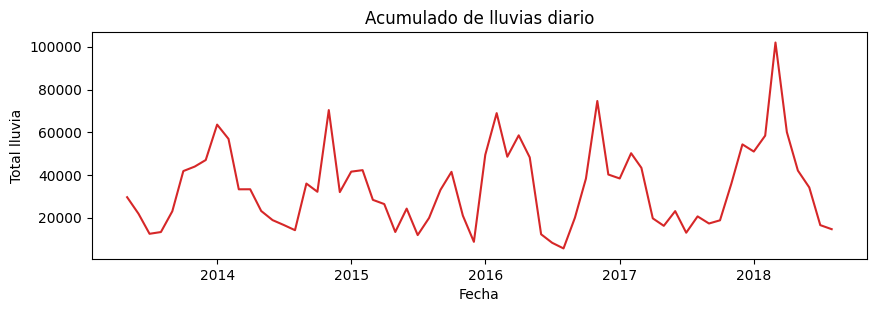

In [ ]:
plot_df(x=data_2_df.index, y=data_2_df['rain_all'],
        title='Acumulado de lluvias diario', xlabel='Fecha',
        ylabel='Total lluvia', dpi=100)

- El residuo también nos puede ayudar a determinar el tipo de modelo. 

- Por lo que procedemos a estudiar la serie a través de su residuo, en el supuesto de que fuera aditiva o multiplicativa.

###Análisis según modelo aditivo

- Establecemos a modo de prueba que estamos ante una serie aditiva.

- Vamos a visualizar y estudiar su componente estacional:

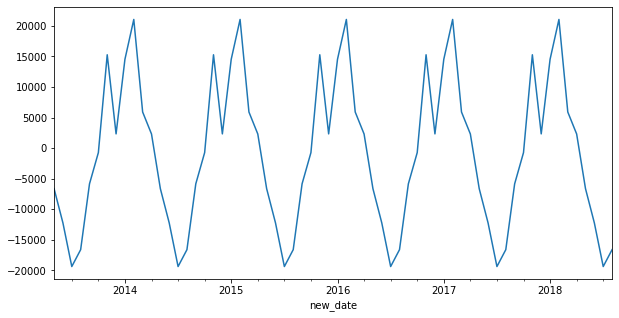

In [ ]:
rcParams['figure.figsize'] = 10, 5
decomposed_ad = seasonal_decompose(data_2_df['rain_all'], model='additive')
decomposed_ad.seasonal.plot();

- La estacionalidad no arroja información relevante, más alla de valores extremos pronunciados y un patrón que se repite en el tiempo. 

- Debemos fijarnos en otros parámetros como el residuo:

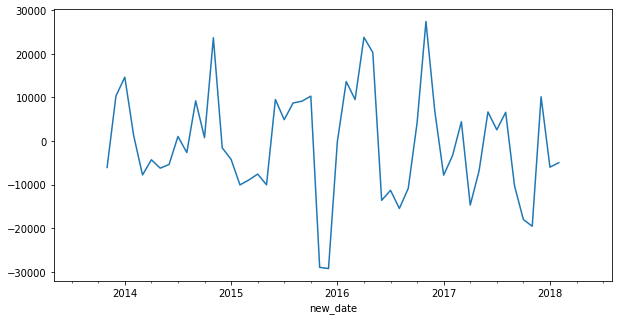

In [ ]:
rcParams['figure.figsize'] = 10, 5
decomposed_ad = seasonal_decompose(data_2_df['rain_all'], model='additive')
decomposed_ad.resid.plot();

- A simple vista parece que la media del residuo podría establecerse entorno a 0 (condición válida para nuestro supuesto). 

- Pero vamos a confirmarlo estudiando los estadísticos medía y desviación estándar del residuo:

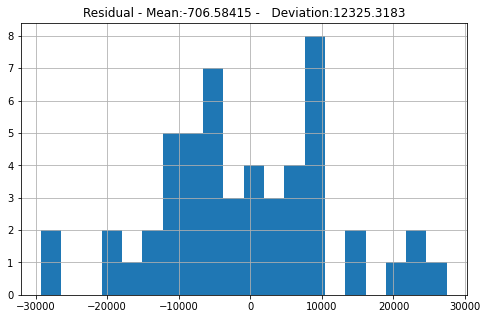

In [ ]:
rcParams['figure.figsize'] = 8, 5
decomposed_ad.resid.hist(bins=20)
plt.title(f"Residual - Mean:{round(decomposed_ad.resid.mean(), 5)} - \
  Deviation:{round(decomposed_ad.resid.std(), 5)}");

Tras calcular y visualizar la estacionalidad, el residuo y sus estadísticos, podemos determinar que:

- La estacionalidad refleja un patrón constante que no cambia a lo largo del tiempo. Este hecho nos invita a pensar que no estamos ante una serie aditiva.  

- La escala de valores del residuo es demasiado grande para tratarse de una serie aditiva.

- El valor de la media del residuo (-706.58415) dista mucho de ser cercano a 0. A lo que se suma el hecho de que la desviación estándar de los valores (12325.3183) nos indica que están alejados de dicha media.  

**Todos estos factores nos indican que no estaríamos ante una serie aditiva. Igualmente vamos a repetir el proceso de análisis con el supuesto de que estuviéramos ante una serie multiplicativa.** 

###Análisis según modelo multiplicativo

- Establecemos a modo de prueba que estamos ante una serie multiplicativa. 

- Vamos a visualizar y estudiar su componente estacional:

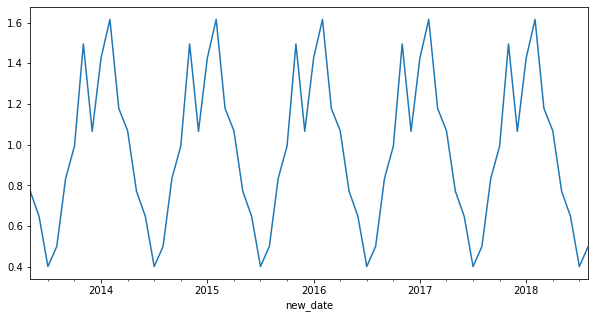

In [ ]:
rcParams['figure.figsize'] = 10, 5
decomposed_mult = seasonal_decompose(data_2_df['rain_all'], model='multiplicative')
decomposed_mult.seasonal.plot();

- En este caso la estacionalidad también refleja un patrón que se repite en el tiempo, pero con una escala de valores mucho más ajustada que el modelo aditivo. 

- De igual manera, vamos a graficar el residuo de este modelo:

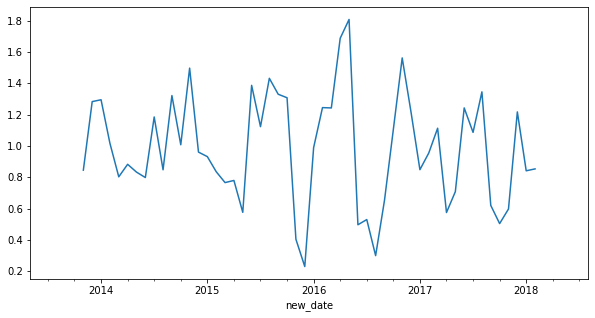

In [ ]:
rcParams['figure.figsize'] = 10, 5
decomposed_mult = seasonal_decompose(data_2_df['rain_all'], model='multiplicative')
decomposed_mult.resid.plot();

- Igualmente parece que la media del residuo podría establecerse entorno a 1 (condición válida para nuestro supuesto). 

- Pero vamos a confirmarlo estudiando los estadísticos medía y desviación estándar del residuo:

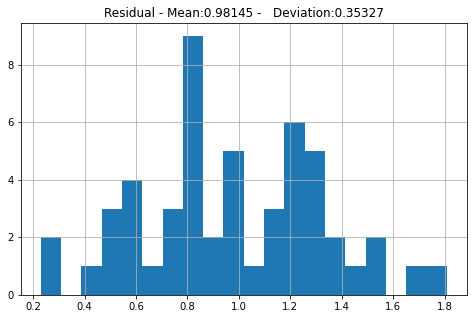

In [ ]:
rcParams['figure.figsize'] = 8, 5
decomposed_mult.resid.hist(bins=20)
plt.title(f"Residual - Mean:{round(decomposed_mult.resid.mean(), 5)} - \
  Deviation:{round(decomposed_mult.resid.std(), 5)}");

Tras calcular y visualizar la estacionalidad, residuo y sus estadísticos podemos determinar que:

- Comprobamos que la estacionalidad refleja igualmente un patrón constante que no cambia a lo largo del tiempo. Pero con una escala de valores mucho más ajustada. Que nos invita a validar el supuesto del modelo multiplicativo.  

- La escala de valores del residuo es mucho más ajustada que la del modelo aditivo. Hecho fundamental para confirmar el modelo multiplicativo

- El valor de la media del residuo (0.98145) es muy cercano a 1. A lo que se suma el hecho de que la desviación estándar de los valores (0.35327) nos indica que están muy cercanos a dicha media.  

**Todos estos factores confirman que estamos ante una serie multiplicativa.** 

##3.- **Decompose** the ts, can you observe a **trend** or a **seasonal component**?

- El método decompose, fijado en un modelo multiplicativo, permite visualizar el desarrollo de la serie, tendencia, estacionalidad y residuo.

- Procedemos a descomponer la serie temporal en función de la variable acumulado de lluvias:

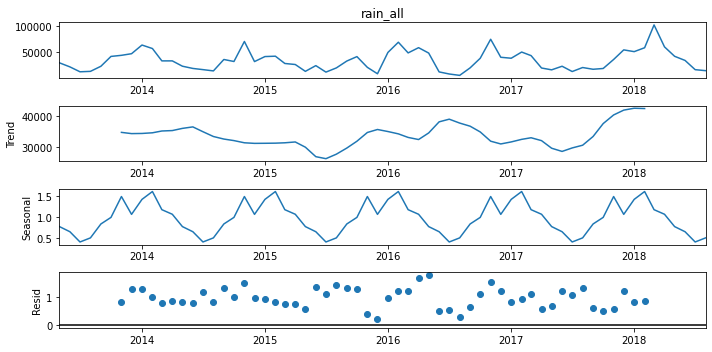

In [ ]:
rcParams['figure.figsize'] = 10, 5
decomposed_mult = seasonal_decompose(data_2_df['rain_all'], model='multiplicative')
decomposed_mult.plot();

A raiz de estas representaciones gráficas, vamos a estudiar las componentes de tendencia y estacionalidad:

###Análisis de tendencia

- Debemos observar si existe un comportamiento de tendencia cíclico, que se repita a lo largo de varios años. De nada sirve tomar como referencia las subidas, bajadas o inflexiones en un menor periodo temporal. 

- Existe un claro descenso en la tendencia desde mediados de 2014 a mediados de 2015 (con el mínimo histórico incluído). Continuado por una recuperación escalonada hasta mediados de 2016. 

- A partir de este punto observamos un comportamiento muy similar. Descenso escalonado hasta mediados de 2017. Continuado por una mayor subida escalonada de precipitaciones, reflejada hasta comienzos de 2018 (final de nuestra serie).

- Podemos pensar que dicha subida se mantendría hasta mediados de 2018. **Confirmando la existencia de subidas y bajadas de precipitaciones, enmarcadas en ciclos temporales de unos 2 años. Que desembocan en una tendencia general de aumento de precipitaciones a lo largo de la serie temporal.** 

###Análisis de estacionalidad
- Anteriorme hemos determinado la existencia de un ciclo temporal de subida y bajada de precipitaciones. Que se repite de forma similar cada dos años.

- Dichas subidas se corresponden con finales y comienzos de año lluviosos. Junto con bajadas de precipitaciones a lo largo de la franja estival. 

- **Por todo ello podemos afirmar la existencia de la estacionalidad reflejada en la serie. Con un comportamiento interanual muy similar de las precipitaciones. Es un patrón periódico que se repite a lo largo del tiempo.**

##4.- Is it **stationary**? If not, which **steps** did you apply to make it stationary?

**A partir de los análisis anteriores, podríamos establecer que no estamos ante una serie estacionaria. Dado que hemos comprobado que:**

- **Cuenta con una tendencia general de subida.**

- **Hay una estacionalidad que se repite periódicamente a lo largo del tiempo.** 

- La varianza cambia sutilmente a lo largo del tiempo, tal y como refleja el valor de desviación estándar del modelo multiplicativo. Es necesario determinar su comportamiento. 

Nos interesa convertir nuestra serie a estacionaria porque:

- La mayoría de modelos parten de la premisa de que la serie es estacionaria. 

- Sus teorías de modelado son más robustas.

Para convertir la serie a estacionaria debemos determinar de qué elementos (tendencia/estacionalidad) podemos deshacernos.

Vamos a hacer una primera comprobación con el método test_stationaity:

- Tomamos como referencia un periodo de n = 12 meses para ver como se comporta nuestra serie. También se ajusta mejor a la naturaleza de los datos. 

- Descartamos un periodo de n = 24, ya que perderíamos mucha información.

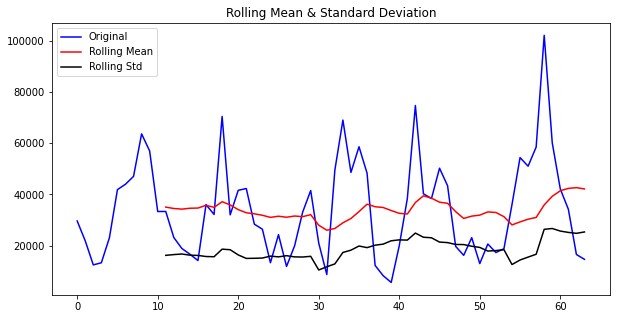

In [ ]:
test_stationarity(data_1_df['rain_all'], 12)

Ya podemos visualizar más correctamente la media móvil. Pero sigue sin ser válida:

- Ya que aún sigue fluctuando.

- Sus valores no se establecen en torno a 0. 

- La desviación estándar (varianza) parece tener una dinámica adecuada, pero creemos que aún se puede suavizar más.

Como medida adicional vamos a establecer una diferenciación mensual en nuestra serie y la vamos a registrar en una nueva variable (dif_mensual).

In [ ]:
data_1_df['dif_mensual'] = data_1_df['rain_all'] - data_1_df['rain_all'].shift(1)
data_1_df.head()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,new_date,dif_mensual
0,29634.3,6141.5,6955.3,9319.2,8591.2,2013-05-01,NaN
1,21886.2,5392.1,5400.1,5654.4,6314.1,2013-06-01,-7748.1
2,12508.8,1863.3,801.9,3006.0,7135.5,2013-07-01,-9377.4
3,13331.8,2288.7,2483.6,3927.3,5233.9,2013-08-01,823.0
4,23053.8,4188.3,4840.3,6940.1,8206.9,2013-09-01,9722.0


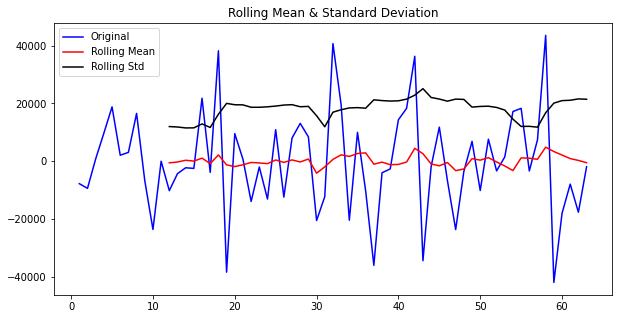

In [ ]:
test_stationarity(data_1_df['dif_mensual'], 12)

Podemos comprobar que:

- **La media se ha situado en torno a 0 con una fluctuación mucho menor.** 
- **También se ha ajustado la escala de la desviación estándar (varianza). Y se ha situado por encima de la media.** 

Anteriormente afirmamos la existencia de una estacionalidad, que imposiblitaba que nuestra serie pudiera ser estacionaria. 

Debemos comprobrar si los ajustes realizados han conseguido eliminar dicha estacionalidad. Una manera de hacerlo, es comprobar como ha cambiado la autocorrelación de los valores con la diferenciación temporal.

Comenzamos mostrando la autocorrelación antes de la diferenciación y descartando los valores nulos:

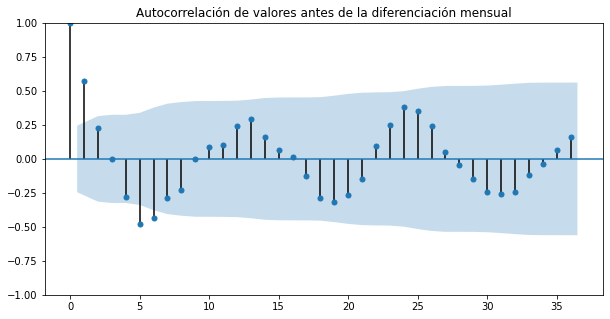

In [ ]:
rcParams['figure.figsize'] = 10, 5
plot_acf(data_1_df['rain_all'].dropna(), lags = 36)
plt.title('Autocorrelación de valores antes de la diferenciación mensual');

- El gráfico anterior de autocorrelación demuestra claramente la estacionalidad, como un patrón que se repite. 

- Los máximos y mínimos están relacionados entre si.

A continuación vamos a mostrar la autocorrelación, aplicando la diferenciación en nuestra serie y descartando los valores nulos:

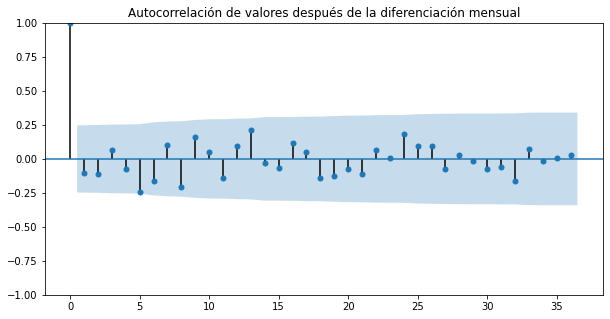

In [ ]:
rcParams['figure.figsize'] = 10, 5
plot_acf(data_1_df['dif_mensual'].dropna(), lags = 36)
plt.title('Autocorrelación de valores después de la diferenciación mensual');

Podemos comprobar que:

- **Efectivamente hemos eliminado la estacionalidad. Ya no se contempla ningún patrón que se repita en el tiempo.**

- **El valor de autocorrelación correspondiente a 5.0 es el de mayor relevancia. Ejemplifica la correlación en la diferencia de precipitaciones, en un salto temporal de unos 6 meses (por ejemplo verano-invierno).**

- **Dado que ya es una serie estacionaria, podemos observar como la correlación decrece rápidamente en el primer paso.**

A continuación vamos a aplicar el test de Dickey Fuller, basado en los siguientes factores:

- Se basa en la validación o no de la hipótesis de raiz unitaria. Según la cual la media y varianza no son constantes a lo largo del tiempo.

- Para descartar la hipótesis, su resultado estadístico debe ser menor que los valores críticos que también va a mostrar. 

- Adicionalmente establece un p-valor (indicador de confianza) entre 0 y 1, que igualmente sirve de referencia para validar o no la hipótesis, comparándolo con el umbral que marquemos (en este caso 0.05). 

- Rechazando la hipótesis de raiz unitaria, según este test podremos afirmar que nuestra serie es estacionaria:  

In [ ]:
interpret_dftest(data_1_df['dif_mensual'].dropna(), 0.05)

ADF Statistic: -4.748529
p-value: 0.000068
Critical Values:
	1%: -3.566
	5%: -2.920
	10%: -2.598
We can reject the null hypothesis. Time series is stationary


Podemos establecer que:

- **El resultado ADF (-4.748529) es menor que los valores críticos (1%, 5% y 10%). Ya podríamos rechazar la hipótesis nula.** 

- **Obtenemos un p-valor (indicador de confianza en la hipótesis de raiz unitaria) muy cercano a 0 (0.000068) y por debajo del umbral de confianza (0.05). De manera que podemos descartar dicha hipótesis de raiz unitaria. Según la cual, nuestra media y varianza no serían constantes a lo largo del tiempo.** 

- **De nuevo según este test: podemos confirmar que nuestra serie es estacionaria.** 

Por último vamos a aplicar el test de KPSS, basado en los siguientes factores:

- Su objetivo es el de comprobar si estacionaria en tendencia o no.

- Para confirmar el comportamiento estacionario de la serie, su resultado estadístico debe ser menor que los valores críticos arrojados por el test.

- Igualmente establece un p-valor (indicador de confianza) entre 0 y 1, que  sirve de referencia para validar o no la hipótesis, comparándolo con el umbral que marquemos (en este caso 0.5).

In [ ]:
interpret_kpss(data_1_df['dif_mensual'].dropna(), 0.5);

kpss Statistic: 0.046642
p-value: 0.100000
Truncation lag parameter: 5.000000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
We can reject the null hypothesis. Time series is stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Podemos establecer que:

- **El resultado kpss (0.149759) es menor que los valores críticos (1%, 2.5%, 5% y 10%).** 

- **Obtenemos un p-valor (0.1) por debajo del umbral marcado (0.5).

- **De nuevo según este test: al haber descartado la tendencia, podemos confirmar que nuestra serie es estacionaria.** 

**Tras aplicar ambos test con resultados afirmativos (según la matriz de decisión), podemos determinar que nuestra serie es estacionaria.**

##5.- Build a **benchmark** model to predict the last 8 periods. Choose an **error measurement** and obtain the error of the prediction.

- Para hacer las predicciones no es necesario que contemos con una serie estacionaria.

- Parseamos sus fechas y las establecemos como índice.

- A continuación comprobaremos la fecha del 1er registro y los 8 últimos.

In [ ]:
data_3_df = pd.read_csv(file_name, sep=';',
                   parse_dates=['new_date'], date_parser=dateparse,
                   index_col='new_date')

In [ ]:
data_3_df.head()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24
new_date,,,,,
2013-05-01,29634.3,6141.5,6955.3,9319.2,8591.2
2013-06-01,21886.2,5392.1,5400.1,5654.4,6314.1
2013-07-01,12508.8,1863.3,801.9,3006.0,7135.5
2013-08-01,13331.8,2288.7,2483.6,3927.3,5233.9
2013-09-01,23053.8,4188.3,4840.3,6940.1,8206.9


In [ ]:
data_3_df.head(1)

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24
new_date,,,,,
2013-05-01,29634.3,6141.5,6955.3,9319.2,8591.2


In [ ]:
data_3_df.tail(8)

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24
new_date,,,,,
2018-01-01,50999.6,11768.8,13418.7,13992.3,12200.1
2018-02-01,58450.3,11652.1,14823.1,18041.7,14654.4
2018-03-01,102026.0,23420.3,25285.3,28059.5,26929.1
2018-04-01,60092.5,14305.5,12576.2,16327.1,17446.3
2018-05-01,42106.1,7781.7,6800.1,13933.0,14194.8
2018-06-01,34203.3,6657.4,6270.9,10628.7,11041.5
2018-07-01,16561.4,2762.6,2897.9,4817.6,6240.4
2018-08-01,14669.9,2365.9,1757.9,4890.7,6025.2


In [ ]:
data_3_df.shape

(64, 5)

Dado que tenemos que establecer un modelo para predecir los 8 últimos periodos, vamos a generar dos datasets adicionales, en los que separaremos los registros del dataset creado anteriormente:

- Vamos a utilizar el primer dataset (data_train) para entrenar nuestro modelo. Prescindiendo de los 8 últimos registros. 

- Utilizaremos el segundo dataset (data_test) para probar nuestro modelo. De modo que vamos a pasarle las últimas 8 filas que no incluímos en el dataset data_train:

- También vamos a comprobar el tamaño de los datasets resultantes y verificar que sus registros no se solapen:

In [ ]:
data_train = data_3_df[:56]
data_test = data_3_df[56:]

In [ ]:
data_train.shape, data_test.shape

((56, 5), (8, 5))

In [ ]:
data_train.tail(1)

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24
new_date,,,,,
2017-12-01,54357.4,15074.8,13938.5,12639.8,13371.7


In [ ]:
data_test.head(1)

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24
new_date,,,,,
2018-01-01,50999.6,11768.8,13418.7,13992.3,12200.1


- A continuación vamos a aplicar diferentes métodos de predicción sobre nuestro dataset de entrenamiento. 

- Registraremos sus resultados como columnas adicionales en nuestro dataset de testeo: 

In [ ]:
data_test['y_hat_mean'] = data_train['rain_all'].mean();

In [ ]:
data_test['y_hat_mean_last_n'] = data_train['rain_all'].rolling(12).mean().iloc[-1];

In [ ]:
data_test['y_hat_naive'] = data_train['rain_all'].iloc[-1];

In [ ]:
data_test['y_hat_naive_seasonal'] = data_train['rain_all'].iloc[-12:][:8].values;

In [ ]:
data_test.head(8)

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,y_hat_mean,y_hat_mean_last_n,y_hat_naive,y_hat_naive_seasonal
new_date,,,,,,,,,
2018-01-01,50999.6,11768.8,13418.7,13992.3,12200.1,32164.496429,29274.516667,54357.4,38400.3
2018-02-01,58450.3,11652.1,14823.1,18041.7,14654.4,32164.496429,29274.516667,54357.4,50214.4
2018-03-01,102026.0,23420.3,25285.3,28059.5,26929.1,32164.496429,29274.516667,54357.4,43374.8
2018-04-01,60092.5,14305.5,12576.2,16327.1,17446.3,32164.496429,29274.516667,54357.4,19736.4
2018-05-01,42106.1,7781.7,6800.1,13933.0,14194.8,32164.496429,29274.516667,54357.4,16238.0
2018-06-01,34203.3,6657.4,6270.9,10628.7,11041.5,32164.496429,29274.516667,54357.4,23121.4
2018-07-01,16561.4,2762.6,2897.9,4817.6,6240.4,32164.496429,29274.516667,54357.4,13014.3
2018-08-01,14669.9,2365.9,1757.9,4890.7,6025.2,32164.496429,29274.516667,54357.4,20654.4


A continuación vamos a visualizar los valores de:

- **El dataset de entrenamiento.**
- **Los valores esperados de testeto.**
- **Todas las predicciones de los últimos 8 periodos.**

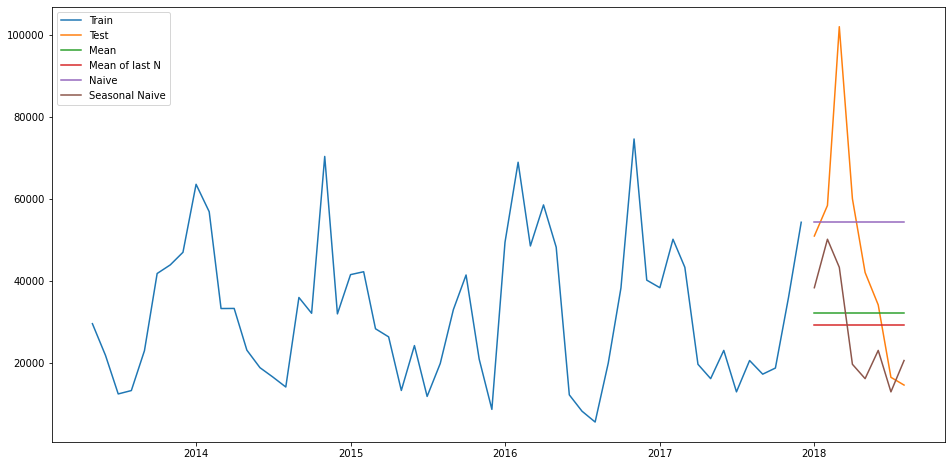

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data_train['rain_all'], label='Train')
plt.plot(data_test['rain_all'], label='Test')
plt.plot(data_test['y_hat_mean'], label='Mean')
plt.plot(data_test['y_hat_mean_last_n'], label='Mean of last N')
plt.plot(data_test['y_hat_naive'], label='Naive')
plt.plot(data_test['y_hat_naive_seasonal'], label='Seasonal Naive')
plt.legend(loc='best')
plt.show()

- Tomamos como referencia la predicción "Seasonal Naive" (Marrón).

- A continuación vamos a descomponer nuestra predicción. Obteniendo el error, junto con su media y desviación estándar (varianza).

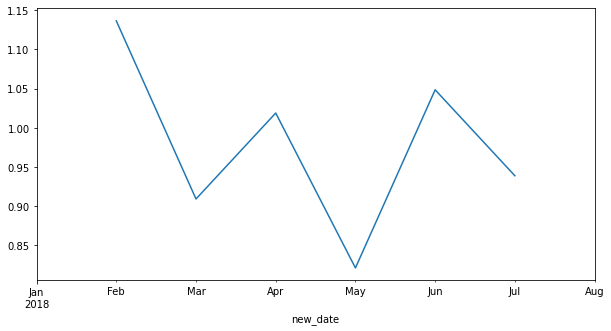

In [ ]:
rcParams['figure.figsize'] = 10, 5
decomposed_mult = seasonal_decompose(data_test['y_hat_naive_seasonal'], period = 3, model='multiplicative')
decomposed_mult.resid.plot();

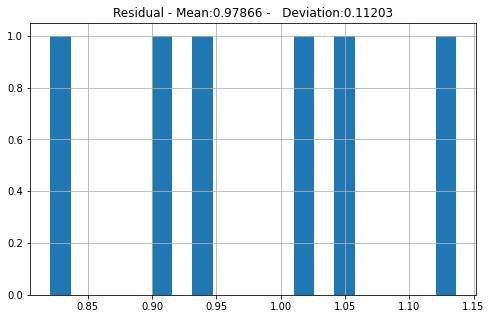

In [ ]:
rcParams['figure.figsize'] = 8, 5
decomposed_mult.resid.hist(bins=20)
plt.title(f"Residual - Mean:{round(decomposed_mult.resid.mean(), 5)} - \
  Deviation:{round(decomposed_mult.resid.std(), 5)}");

- **Obtenemos un error con una escala muy ajustada.**

- **Su media (0.97866) es muy cercana a 1 (valor deseado para una serie multiplicativa).**

- **Su desviación (0.11203) es aceptable.**

**Todos estos hechos nos indican que el modelo de predicción "Seasonal Naive" es acertado.**

**Si ampliáramos nuestro horizonte, aumentando el número de predicciones, provocaríamos que el error aumentara aún más.**

##6.- Build an **AR** or a **MA** model. How does the **error** change?

Tanto el modelo AR como el MA precisan que nuestra serie sea estacionaria. Por lo que nuevamente vamos a:
- Generar un nuevo dataframe. En el vamos a parsear el fichero original.
- Fijamos la columna de fechas como nuestro índice.

In [ ]:
dateparse = lambda dates: dt.datetime.strptime(dates, '%Y-%m-%d')
data_4_df = pd.read_csv(file_name, sep=';',
                   parse_dates=['new_date'], date_parser=dateparse,
                   index_col='new_date')

- Creamos una nueva columna en la que registramos una diferenciación temporal.

In [ ]:
data_4_df['seasonal_diff'] = data_4_df['rain_all'] - data_4_df['rain_all'].shift(1)

- Procedemos a analizar la serie resultante con el test de Dickey-Fuller. Nuestro obejtivo es validar que la serie diferenciada es estacionaria.

In [ ]:
interpret_dftest(data_4_df['seasonal_diff'].dropna(), 0.05)

ADF Statistic: -4.748529
p-value: 0.000068
Critical Values:
	1%: -3.566
	5%: -2.920
	10%: -2.598
We can reject the null hypothesis. Time series is stationary


Podemos establecer que:

- **El resultado ADF (-4.748529) es menor que los valores críticos (1%, 5% y 10%). Ya podríamos rechazar la hipótesis nula.** 

- **Obtenemos un p-valor (indicador de confianza en la hipótesis de raiz unitaria) muy cercano a 0 (0.000068) y por debajo del umbral de confianza (0.05). De manera que podemos descartar dicha hipótesis de raiz unitaria. Según la cual, nuestra media y varianza no serían constantes a lo largo del tiempo.** 

- **Ya podemos afirmar que contamos con una serie estacionaria.**

Acto seguido vamos a emplear un método para visualizar las funciones de autocorrelación general y parcial. A partir de las representaciones vamos a:

- Elegir qué modelo de predicción (AR O MA) se ajusta más a la dinámica de nuestros datos. 

- El valor de referencia que va a marcar el orden del modelo elegido. 

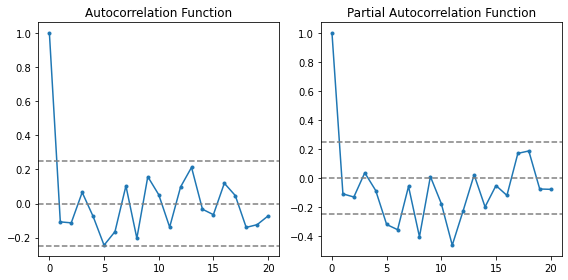

In [ ]:
obtain_order_model(data_4_df['seasonal_diff'].dropna())

Dado el gráfico de autocorrelación podemos establecer que:

- **El modelo que deberíamos construir sería el de media móvil (MA). Ya que la función de autocorrelación desciende súbitamente.** 

- **En el gráfico de autocorrelación normal podemos observar que todos los valores de referencia quedan dentro de nuestro umbral. 5 es el único que se acerca más al umbral inferior.** 

A continuación vamos a generar dos datasets adicionales, en los que separaremos los registros de la serie:

- Vamos a utilizar el primer dataset (data_train) para entrenar nuestro modelo. Prescindiendo de los 12 últimos registros. 

- Utilizaremos el segundo dataset (data_test) para probar nuestro modelo. De modo que vamos a pasarle las últimas 12 filas que no incluímos en el dataset data_train:

- También vamos a comprobar el tamaño de los datasets resultantes y verificar que sus registros no se solapen:

In [ ]:
data_4_df.tail(13)

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,seasonal_diff
new_date,,,,,,
2017-08-01,20654.4,4081.5,3558.6,6431.7,6916.6,7640.1
2017-09-01,17329.0,4446.7,4537.2,4754.1,3751.9,-3325.4
2017-10-01,18820.2,4849.4,5537.8,4975.0,3661.1,1491.2
2017-11-01,36033.6,9714.2,8442.6,7719.3,10380.1,17213.4
2017-12-01,54357.4,15074.8,13938.5,12639.8,13371.7,18323.8
2018-01-01,50999.6,11768.8,13418.7,13992.3,12200.1,-3357.8
2018-02-01,58450.3,11652.1,14823.1,18041.7,14654.4,7450.7
2018-03-01,102026.0,23420.3,25285.3,28059.5,26929.1,43575.7
2018-04-01,60092.5,14305.5,12576.2,16327.1,17446.3,-41933.5


In [ ]:
data_train = data_4_df[:'2017-08-01']
data_test = data_4_df['2017-09-01':]

In [ ]:
data_train.shape, data_test.shape

((52, 6), (12, 6))

A continuación:

- Inicializamos el modelo de entrenamiento MA descartando nulos y marcamos un orden de 5.

- Comenzamos a entrenarlo.

- Mostramos sus resultados por pantalla.

In [ ]:
model_ma = ARIMA(data_train['seasonal_diff'].dropna(), order=(0, 0, 5))  
model_ma_fitted = model_ma.fit()

                               SARIMAX Results                                
Dep. Variable:          seasonal_diff   No. Observations:                   51
Model:                 ARIMA(0, 0, 5)   Log Likelihood                -562.490
Date:                Sun, 23 Oct 2022   AIC                           1138.979
Time:                        22:24:25   BIC                           1152.502
Sample:                    06-01-2013   HQIC                          1144.147
                         - 08-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -176.0543    385.792     -0.456      0.648    -932.194     580.085
ma.L1         -0.3601      0.286     -1.259      0.208      -0.920       0.200
ma.L2         -0.0668      0.195     -0.344      0.7

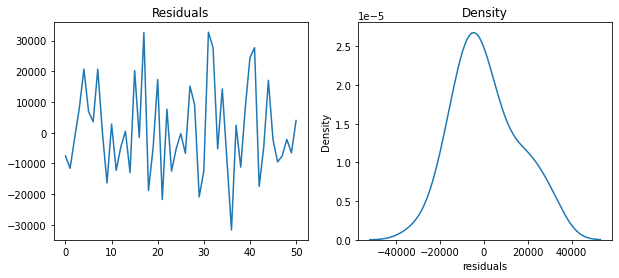

In [ ]:
model_summary_results(model_ma_fitted)

- El resultado AIC (1138.979) nos indica el error de nuestro modelo y se puede utilizar para compararlo con otros modelos.

- La escala del residuo es demasiado grande. Puede que esté guardando más información de la necesaria. Este hecho podría indicarnos que el modelo está dejando de capturar ciertos valores.  

- Acto seguido vamos a utilizar un método de predicción (forecast) para intentar determinar los últimos 8 registros. 

- También vamos a visualizar dicha predicción a la vez que los datos de entrenamiento y testeo:

In [ ]:
forecast = model_ma_fitted.forecast(8, alpha=0.05)
fc_series = pd.Series(forecast, index=data_test.index)

In [ ]:
forecast = model_ma_fitted.forecast(8, alpha=0.05)

In [ ]:
fc_series = pd.Series(forecast, index=data_test.index)

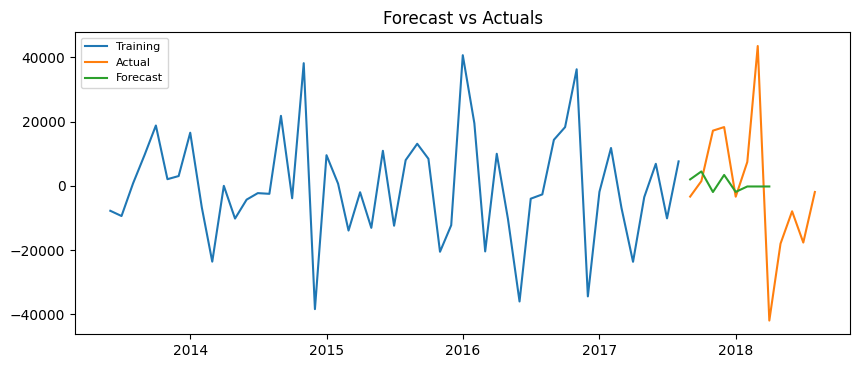

In [ ]:
forecast_plot(data_test['seasonal_diff'], data_train['seasonal_diff'], fc_series)

- La prediccion no es buena. Ya que no arroja ningún resultado parecido a nuestros valores de entrenamiento y testeo.  

- Tenemos que desarrollar otros modelos para alcanzar mejores resultados. 

- Por último recuperamos los errores con otra función:

In [ ]:
data_test['MA_pred'] = fc_series

In [ ]:
forecast_accuracy(data_test['MA_pred'], data_test['seasonal_diff'])

{'me': -4221.579191501479,
 'mae': 17128.3463447091,
 'mape': 1.128207420964525,
 'rmse': 23301.416817386045}

##7.- Build an **ARIMA** or **SARIMA** model. How does it affect to the **error**?

Voy a probar con los dos modelos. Para poder obtener mejores conclusiones comparando sus resultados. 

###Construcción de modelo ARIMA

- Debemos recordar que el orden del modelo ARIMA debería ser el valor mínimo, que convierte nuestra serie en estacionaria.

- Anteriormente comprobamos que los valores del autocorrelograma parcial que pueden marcar el orden de AR son (5, 6, 8, 11). 

- De igual manera comprobamos que el valor del autocorrelograma normal que puede marcar el orden de MA es 5. 

- Vamos a hacer varias pruebas iteraciones aumentando los valores de AR y MA, comprobando el comportamiento del error. 

- Comenzamos a entrenarlo.

- Mostramos sus resultados por pantalla.

In [ ]:
model_arima = ARIMA(data_train['seasonal_diff'].dropna(), order=(6, 1, 5))  
model_arima_fitted = model_arima.fit()

                               SARIMAX Results                                
Dep. Variable:          seasonal_diff   No. Observations:                   51
Model:                 ARIMA(6, 1, 5)   Log Likelihood                -549.934
Date:                Sun, 23 Oct 2022   AIC                           1123.867
Time:                        22:24:29   BIC                           1146.812
Sample:                    06-01-2013   HQIC                          1132.605
                         - 08-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1040      0.346     -0.301      0.764      -0.782       0.574
ar.L2          0.2506      0.383      0.654      0.513      -0.501       1.002
ar.L3          0.3380      0.182      1.854      0.0

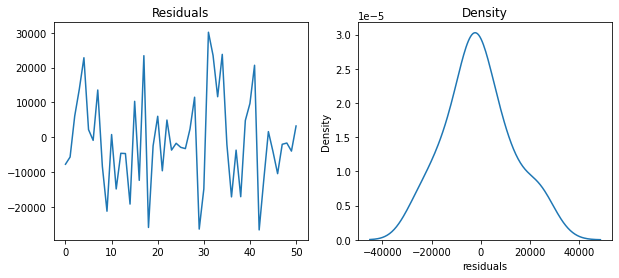

In [ ]:
model_summary_results(model_arima_fitted)

- Hemos fijado el orden en (6, 1, 5).

- El error AIC de ARIMA (1123.867) es ligeramente inferior al del modelo MA (1138.979). 

- Tenemos coeficientes relativamente alejados de 0 y p-valores distantes de 1.

- Observamos un ajuste en la escala de residuos.

###Construcción de modelo SARIMA

- SARIMA añade las componentes estacionales (que no soporta Arima) con una diferenciación. Añadimos los periodos a un modelo sencillo que no era capaz de manejarlos. Vendría a ser como un arima sobre otro arima SARIMA(p, d, q) x (P, D, Q).

- Para marcar los componentes correspondientes a AR, debemos fijarnos en las deltas que quedaban fuera del umbral del autocorrelograma parcial y que sean múltiplos de 12. En este caso contamos con (5, 6, 8, 11) y ninguna de ellas es múltiplo de 12 (orden P = 0).   

- Para marcar los componentes correspondientes a MA debemos fijarnos en las deltas que que quedaban fuera del umbral del autocorrelograma normal y que sean múltiplos de 12. Y no contamos con ninguna (orden Q = 0).  
    
- Vamos a hacer una prueba, fijando una diferenciación inicial de orden estacional con valor 1 (D) junto con un periodo de 12. Estableciendo el orden estacional para el modelo SARIMA en (0, 1, 0, 12).

- Comenzamos a entrenarlo.

- Mostramos sus resultados por pantalla.

In [ ]:
model_sarima = SARIMAX(data_train['seasonal_diff'].dropna(),
                       order=(6, 1, 5),
                       seasonal_order=(0, 1, 0, 12))
model_sarima_fitted = model_sarima.fit();

                                      SARIMAX Results                                      
Dep. Variable:                       seasonal_diff   No. Observations:                   51
Model:             SARIMAX(6, 1, 5)x(0, 1, [], 12)   Log Likelihood                -420.085
Date:                             Sun, 23 Oct 2022   AIC                            864.169
Time:                                     22:24:33   BIC                            883.820
Sample:                                 06-01-2013   HQIC                           871.161
                                      - 08-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0895      0.405     -2.690      0.007      -1.883      -0.296
ar.L2         -0.6723      

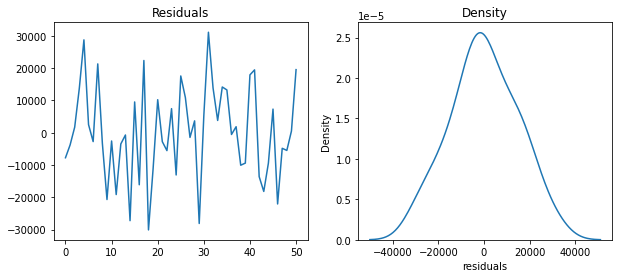

In [ ]:
model_summary_results(model_sarima_fitted)

Podemos comprobar que añadiendo un orden estacional de (0, 1, 0, 12) hemos conseguido:

- **Obtener un error AIC (864.169) bastante menor que el de nuestro modelo ARIMA (1123.867).**

- **Los coefcientes siguen teniendo valores relativamente alejados de 0. Los p-valores están relativamente distanciados de 1.**

- **Observamos un comportamiento de la densidad menos sesgado y más parecido a una distribución normal.**

**Por todo ello podemos decir que es preferible el modelo SARIMA por encima de ARIMA. Ya que la inclusión de la componente estacional mejora los resultados obtenidos.**

###Predicción de modelo SARIMA

In [ ]:
forecast = model_sarima_fitted.forecast(8, alpha=0.05)

In [ ]:
fc_series = pd.Series(forecast, index=data_test.index)

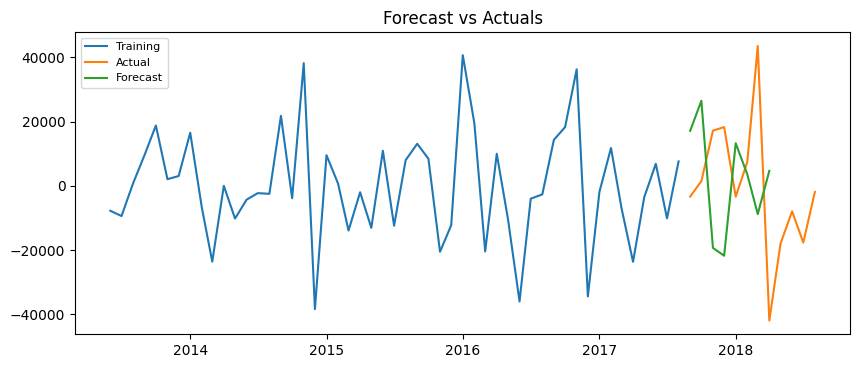

In [ ]:
forecast_plot(data_test['seasonal_diff'], data_train['seasonal_diff'], fc_series)

- La prediccion es más acertada que la del modelo Ma. 

- Por último recuperamos los errores con otra función:

In [ ]:
data_test['SARIMA_pred'] = fc_series

In [ ]:
forecast_accuracy(data_test['SARIMA_pred'], data_test['seasonal_diff'])

{'me': -3001.977770499585,
 'mae': 30199.905204007926,
 'mape': 4.38070421990455,
 'rmse': 33897.22752732047}

##8.- Use **auto_arima** functionality, how does it affect to the **error**?

- Esta funcionalidad proporciona un enfoque gradual para buscar múltiples combinaciones de p, d, q.

- Nos devuelve el modelo que tenga el valor de AIC más ajustado.

- En el caso de que contáramos con numerosas series, requeriría de mucho tiempo y un notable dominio por parte del usuario.

- A continuación vamos a usar AUTOARIMA sin estacionalidad y con ella. Para poder obtener mejores conclusiones comparando sus resultados:  

###AUTOARIMA sin estacionalidad

- Marcamos los inicios de orden de p y q en 1. Pudiendo alcanzar un máximo de 11 (el mayor de los valores significativos que quedaba fuera del umbral de confianza).

- Por último inicializamos esta funcionalidad y mostramos los resultados por pantalla:

In [ ]:
model_autoarima_fitted = pm.auto_arima(data_train.rain_all, 
                                start_p=0, start_q=0, # initial values of p and q
                                test='adf',           # use adftest to find optimal 'd'
                                max_p=11, max_q=5,     # maximum p and q
                                m=1,                  # frequency of series, 1 means no seasonal data
                                d=None,               # let model determine 'd'
                                seasonal=False,       # No Seasonality
                                start_P=0,
                                D=1,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1242.103, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1162.530, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1213.741, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1164.189, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1164.166, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1151.617, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1165.739, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1152.464, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1152.844, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1153.209, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1154.783, Time=0.23 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.864 seconds


In [ ]:
print(model_autoarima_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   52
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -572.808
Date:                Sun, 23 Oct 2022   AIC                           1151.617
Time:                        22:24:36   BIC                           1157.470
Sample:                    05-01-2013   HQIC                          1153.861
                         - 08-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.53e+04   5110.524      2.993      0.003    5281.332    2.53e+04
ar.L1          0.5191      0.132      3.934      0.000       0.261       0.778
sigma2      2.193e+08      0.215   1.02e+09      0.0

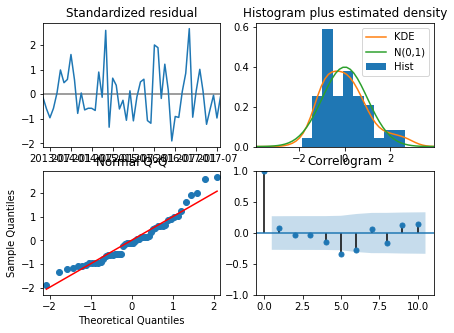

In [ ]:
model_autoarima_fitted.plot_diagnostics(figsize=(7,5))
plt.show()

A partir de los resultados de AUTOARIMA sin estacionalidad podemos establecer que:

- **El modelo recomendado de ARIMA tiene un orden (1, 0, 0).**

- **Valor de error AIC (1151.617) algo superior que nuestros modelos MA (1138.979), ARIMA (1123.867) y SARIMA (864.169).**

- **Cuenta con un coeficiente (0.5191) y p-valor (0.000) con buenos valores.**

- **El residuo estandarizado refleja que hay información que se nos sigue escapando.**

- **Histograma relativamente parecido a una Gaussiana (distribución normal).**

- **Las representaciones normal y correlograma confirman que hay datos que podríamos estar perdiendo.**

###AUTOARIMA con estacionalidad

- Igualmente marcamos los inicios de orden de p y q en 1. Pudiendo alcanzar un máximo de 11 (el mayor de los valores significativos que quedaba fuera del umbral de confianza).

- Afirmamos la estacionalidad, marcando un periodo de 12 (meses).

- Por último inicializamos esta funcionalidad y mostramos los resultados por pantalla:

In [ ]:
model_sarima_pmdarima_fitted = pm.auto_arima(data_train.rain_all, 
                             start_p=1, start_q=1,
                             test='adf',
                             max_p=11, max_q=5,
                             m=12,              # month wise series
                             d=None,
                             seasonal=True,     # For seasonal arima
                             start_P=0,
                             D=1, # For seasonal arima
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=900.137, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=911.083, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=893.958, Time=0.48 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=898.711, Time=0.41 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=909.180, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=908.948, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=894.854, Time=0.71 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=894.996, Time=0.72 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=896.886, Time=0.37 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=896.851, Time=1.23 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=896.321, Time=0.54 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=895.953, Time=0.50 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=897.334, Time=0.61 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=897.305, Time=0.24 sec
 ARIMA(2,0,1)(1,1,0)[12] intercep

In [ ]:
print(model_sarima_pmdarima_fitted.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   52
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -442.957
Date:                            Sun, 23 Oct 2022   AIC                            891.914
Time:                                    22:24:53   BIC                            896.981
Sample:                                05-01-2013   HQIC                           893.746
                                     - 08-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5920      0.227      2.607      0.009       0.147       1.037
ar.S.L12      -0.7258      0.206   

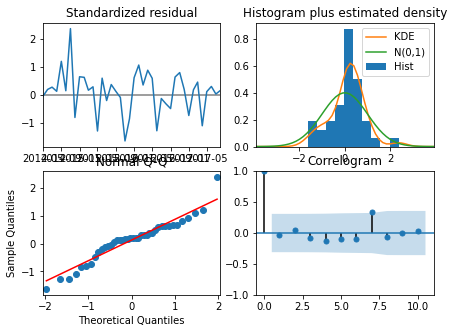

In [ ]:
model_sarima_pmdarima_fitted.plot_diagnostics(figsize=(7,5))
plt.show()

A partir de los resultados de AUTOARIMA con estacionalidad podemos establecer que:

- **El modelo recomendado de ARIMA con estacionalidad tiene un orden (1,0,0)(1,1,0)[12].**

- **Valor de error AIC (1086.458) es más ajustado que el de MA (1138.979), ARIMA (1123.867) y AUTOARIMA sin estacionalidad (1151.617). Pero mayor que el de SARIMA (864.169).**

- **El residuo estandarizado refleja que hay información que se nos sigue escapando. Aunque en menor cantidad que el AUTOARIMA sin estacionalidad.**

- **Histograma aún más parecido a una Gaussiana (distribución normal).**

- **Las representación normal confirma que hay datos que podríamos estar perdiendo. Pero con una  dispersión menor que la del el AUTOARIMA sin estacionalidad.**

- **Por último recuperamos los errores con otra función:**

In [ ]:
forecast = model_autoarima_fitted.predict(n_periods=8)
data_test['y_hat_autoarima'] = forecast
fc_series = pd.Series(forecast, index=data_test.index)

In [ ]:
forecast_accuracy(data_test['y_hat_autoarima'], data_test['rain_all'])

{'me': -19448.89216887304,
 'mae': 24117.95595678984,
 'mape': 0.45338147048178534,
 'rmse': 30839.98595324879}

##9.- Build a model with **Prophet**, does the **error** increase or decrease?



- **Este modelo ofrece elementos para hacer el flujo de trabajo integro.**

- **Es más potente y tiene muchos más parámetros que los modelos vistos anteriormente.**

- **Permite crear componentes periódicas personalizadas con series de Fourier.**

- Parseamos los valores del fichero original y los volcamos en un nuevo dataset (sin modificar el dataset original).

- Según las indicaciones, estableceremos las columnas "ds" e "y" a las que pasaremos, respectivamente, fechas y variable de referencia ("rain_all").

In [ ]:
dateparse = lambda dates: dt.datetime.strptime(dates, '%Y-%m-%d')
data_5_df = pd.read_csv(file_name, sep=';',
                   parse_dates=['new_date'], date_parser=dateparse)

In [ ]:
data_5_df.dtypes

rain_all             float64
rain_00_06           float64
rain_06_12           float64
rain_12_18           float64
rain_18_24           float64
new_date      datetime64[ns]
dtype: object

In [ ]:
data_5_df['Month'] = pd.DatetimeIndex(data_5_df['new_date'])
data_5_df.dtypes

rain_all             float64
rain_00_06           float64
rain_06_12           float64
rain_12_18           float64
rain_18_24           float64
new_date      datetime64[ns]
Month         datetime64[ns]
dtype: object

In [ ]:
data_5_df = data_5_df.rename(columns={'Month': 'ds',
                            'rain_all': 'y'})

data_5_df.head(1)

,y,rain_00_06,rain_06_12,rain_12_18,rain_18_24,new_date,ds
0,29634.3,6141.5,6955.3,9319.2,8591.2,2013-05-01,2013-05-01


###Modelo Básico

- Creamos la variable con el intérvalo de confianza deseado. 

- Le pasamos los datos para que se entrene.

In [ ]:
my_model_basic = Prophet(interval_width=0.95) # default value is 80%
my_model_basic

In [ ]:
 my_model_basic.fit(data_5_df) # comenzamos a entrenarlo

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


###Predicciones

- Construímos un dataframe para hacer la predicción del futuro. Pasándole los periodos y frecuencia con los que queremos trabajar.

In [ ]:
future_dates = my_model_basic.make_future_dataframe(periods=8, freq='MS')

- Vamos a comprobar el tamaño del dataframe resultante:

In [ ]:
future_dates.shape

(72, 1)

In [ ]:
future_dates.head(1)

,ds
0,2013-05-01


In [ ]:
future_dates.tail(1)

,ds
71,2019-04-01


- Guardamos la predicción del modelo básico en una variable y utilizamos el dataset de fechas futuras.

In [ ]:
forecast = my_model_basic.predict(future_dates)

In [ ]:
forecast.tail(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
71,2019-04-01,44804.309323,13958.225583,60334.167956,44804.107645,44804.515246,-7030.939826,-7030.939826,-7030.939826,-7030.939826,-7030.939826,-7030.939826,0.0,0.0,0.0,37773.369497


- **Este método de predicción nos ha entregado multitud de variables con diversa información.**

- **Nos quedamos con las más relevantes, para analizar los resultados con más facilidad.**

- **yhat_lower e yhat_upper marcan nuestro intérvalo de confianza al 95%.** 

- **Hay cierta aleatoriedad limitada en los valores, debido al método de predicción que utiliza Prophet (Método de Montecarlo).**

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']].tail(1)

,ds,yhat,yhat_lower,yhat_upper,trend
71,2019-04-01,37773.369497,13958.225583,60334.167956,44804.309323


In [ ]:
my_model_basic = Prophet(interval_width=0.95)
my_model_basic.fit(data_5_df)
my_model_basic.predict(future_dates)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
71,2019-04-01,37773.369497,14536.201976,60549.983976


###Análisis de resultados

- Procedemos a visualizar la predicción junto con los intérvalos de confianza. 

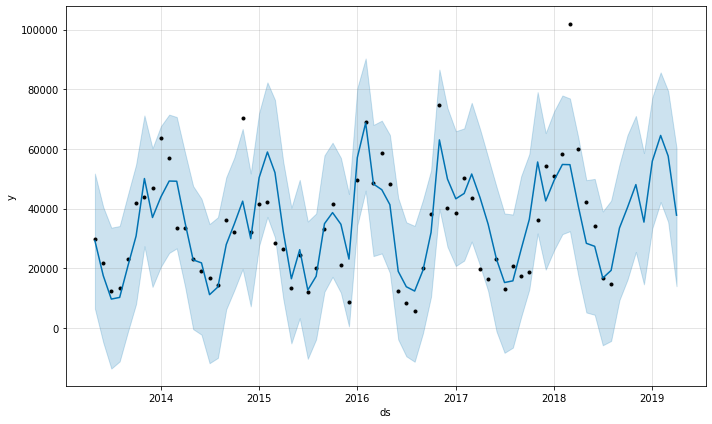

In [ ]:
my_model_basic.plot(forecast, uncertainty=True);

- **Casi todos los valores reales quedan dentro de nuestro intérvalo de confianza.** 

- **Hay cierta desviación entre unos cuantos de estos valores y la línea de predicción de nuestro modelo.**  

- A continuación vamos a recuperar los diferentes componentes de este modelo:

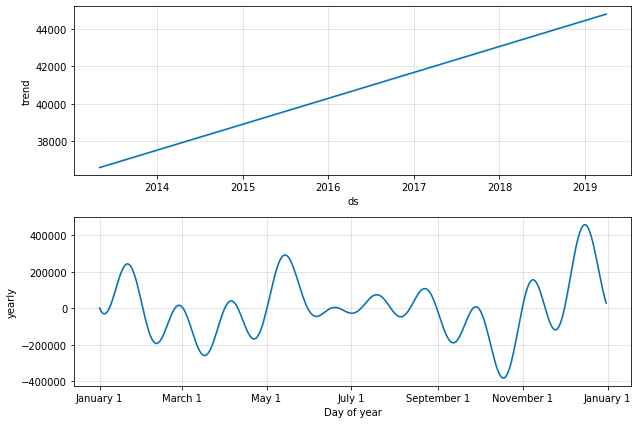

In [ ]:
my_model_basic.plot_components(forecast);

- Podemos comprobar una clara tendencia a lo largo de los años (en este caso partimos de una serie no estacionaria).

- Un componente calculado por Fourier, que refleja variaciones a lo largo de todo un año. 

###Puntos de cambio

- Prophet es capaz de detectar los puntos en los que la tendencia cambia.

- Estima que puede haber 25 puntos potenciales que pueden cambiar la tendencia. Los distribuye a lo largo del 80% de nuestra serie. Los regulariza y se queda con los más importantes. 

A continuación vamos a intentar visualizar y rescatar el valor de dichos puntos: 

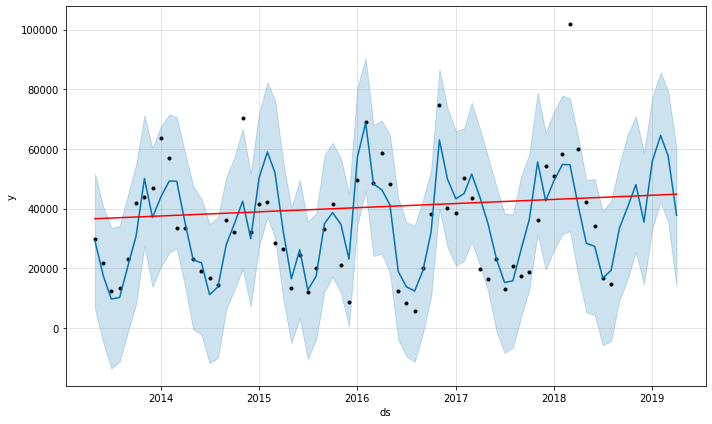

In [ ]:
fig = my_model_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model_basic, forecast)

- La representación gráfica no refleja ningún punto que cambie la tendencia ascendente. 

- Vamos a intentar obtener dichos puntos concretos con otro método:

In [ ]:
my_model_basic.changepoints

2    2013-07-01
4    2013-09-01
6    2013-11-01
8    2014-01-01
10   2014-03-01
12   2014-05-01
14   2014-07-01
16   2014-09-01
18   2014-11-01
20   2015-01-01
22   2015-03-01
24   2015-05-01
26   2015-07-01
28   2015-09-01
30   2015-11-01
32   2016-01-01
34   2016-03-01
36   2016-05-01
38   2016-07-01
40   2016-09-01
42   2016-11-01
44   2017-01-01
46   2017-03-01
48   2017-05-01
50   2017-07-01
Name: ds, dtype: datetime64[ns]

In [ ]:
len(my_model_basic.changepoints)

25

In [ ]:
my_model_basic.changepoints[
        np.abs(np.nanmean(my_model_basic.params['delta'], axis=0)) >= 0.01
    ]

Series([], Name: ds, dtype: datetime64[ns])

In [ ]:
my_model_basic.params['delta']

array([[-5.43359886e-11, -6.86676158e-11,  1.88718232e-10,
         1.91970081e-10,  1.58715184e-10,  3.51171180e-11,
         6.70668412e-11,  1.29532864e-10,  1.07255530e-10,
         1.95287358e-10,  1.39310151e-10,  2.42106676e-08,
         1.38001106e-10,  2.50898385e-10,  2.62722999e-10,
         3.51997788e-10,  5.80124867e-05,  6.94111927e-05,
         2.95335164e-10,  1.59425921e-10, -7.85705227e-11,
         1.34284610e-10,  4.44157558e-08,  3.23534313e-11,
         8.14306153e-11]])

- Podemos ver que noy hay ningún coeficiente siginificativo. Ya que todos ellos tienen una escala muy pequeña. 

In [ ]:
len(my_model_basic.params['delta'][0])

25

In [ ]:
my_model_basic.params['delta'][0][my_model_basic.params['delta'][0] > 0.01]

array([], dtype=float64)

- Ninguno de los 25 puntos escogidos por Prophet supone un cambio en la tendencia. Por lo que al pedir directamente los puntos significativos, nos entrega un array vacío. 

Vamos a aplicar dos ajustes en los parámetros para intentar encontrar dichos puntos de cambio de tendencia: 

- Podemos usar una mayor parte de la serie para disponerlos (hasta un 90% en lugar de 80%). Pero sin resultado favorable, como vemos a continuación:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


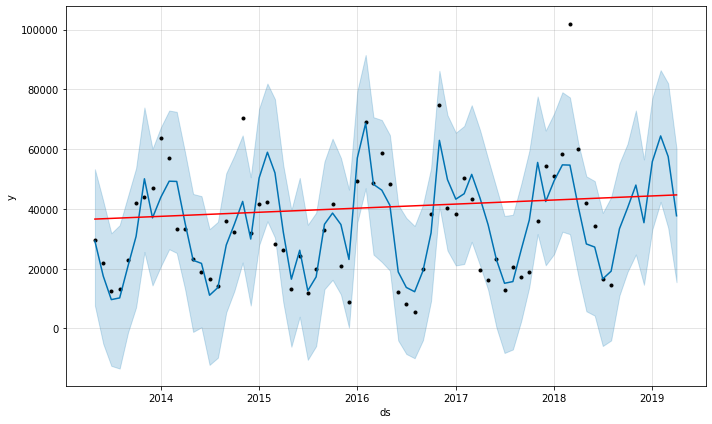

In [ ]:
my_model_chp_range = Prophet(interval_width=0.95, changepoint_range=0.9)
my_model_chp_range.fit(data_5_df)
forecast_chp_range = my_model_chp_range.predict(future_dates)
fig = my_model_chp_range.plot(forecast_chp_range)
a = add_changepoints_to_plot(fig.gca(), my_model_chp_range, forecast_chp_range)

- Si aumentamos la flexibilidad de la escala, acabamos obteniendo tres puntos que reflejan los cambios en la nueva tendencia:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


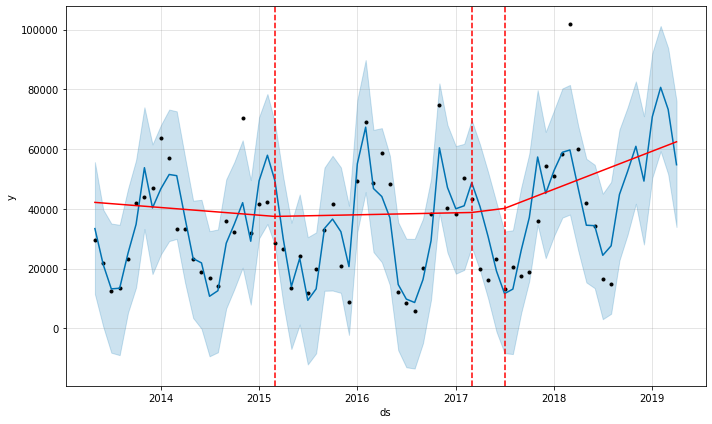

In [ ]:
my_model_chp_prior = Prophet(interval_width=0.95, changepoint_prior_scale=0.5)
my_model_chp_prior.fit(data_5_df)
forecast_chp_prior = my_model_chp_prior.predict(future_dates)
fig = my_model_chp_prior.plot(forecast_chp_prior)
a = add_changepoints_to_plot(fig.gca(), my_model_chp_prior, forecast_chp_prior)

###Componentes estacionales

- Creamos una nueva variable de modelo estacional, en la que vamos a registrar el desarrollo de Prophet. Marcando una estacionalidad anual. 

- Le añadimos una componente estacional de periodo mensual y con orden de Fourier 5.

In [ ]:
my_model_seasonal = Prophet(interval_width=0.95,
                            yearly_seasonality = True,
                            weekly_seasonality = False,
                            daily_seasonality = False)

In [ ]:
my_model_seasonal.add_seasonality(name='monthly',
                                  period=30.5,
                                  fourier_order=5)

- Comenzamos a entrenar nuestro modelo.

- Aplicamos el método de predicción sobre dicho modelo

- Procedemos a visualizar los componentes del modelo estacional sobre la predicción.

In [ ]:
my_model_seasonal.fit(data_5_df)

In [ ]:
forecast_seasonal = my_model_seasonal.predict(future_dates)

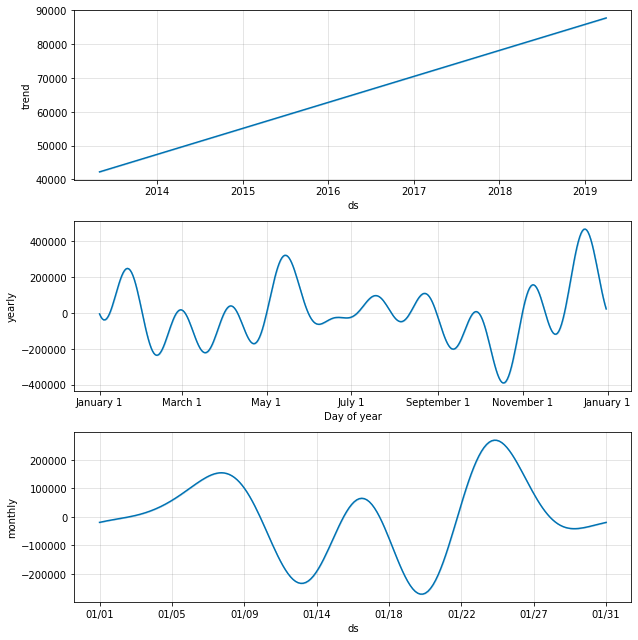

In [ ]:
my_model_seasonal.plot_components(forecast_seasonal);

Esta representación gráfica nos muestra información muy relevante:

- Comportamiento de la tendencia a lo largo de los años.

- Evolución mensual comparativa a lo largo de todos los meses del año. 

- Evolución diaria comparativa a lo largo de todos los días del mes. 

- Prophet también nos permite ajustar los pesos de cada marca temporal, estableciendo su relevancia (ej: afluencia de clientes por día de la semana).

###Medida de error



- Vamos a utilizar una función que compara los valores de la predicción con los reales. 

- Nos devuelve el error medio, error medio absoluto, el error absoluto medio porcentual y el error cuadrático medio.  

In [ ]:
data_5_df.head(1)

,y,rain_00_06,rain_06_12,rain_12_18,rain_18_24,new_date,ds
0,29634.3,6141.5,6955.3,9319.2,8591.2,2013-05-01,2013-05-01


In [ ]:
forecast.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-05-01,36584.631278,6419.669488,51727.688256,36584.631278,36584.631278,-7362.668671,-7362.668671,-7362.668671,-7362.668671,-7362.668671,-7362.668671,0.0,0.0,0.0,29221.962607


In [ ]:
forecast_accuracy(forecast.yhat, data_5_df.y)

{'me': 1.322888908318646,
 'mae': 8268.239417308641,
 'mape': 0.2948473344027627,
 'rmse': 11712.403170961143}

- **A partir de los valores de los errores, podemos comprobar la gran calidad de este modelo de predicción.**

- **El error desciende en gran medida comparándolo con otros modelos. Con un error medio de poco más de un punto (1.32288...) y un porcentual por debajo del 30% (0.29484...).**

- **Podemos decir, sin duda alguna, que Prophet es una gran herramienta de modelado y predicción.**

##10.- Finally, which is the **best** model?

Vamos a recuperar los resultados de cada modelo, destacando sus puntos débiles y fuertes:

###Modelo MA

- Arroja un resultado de error AIC (1138.979) bastante abultado.

- Coeficientes distintos de 0 y p-valores (P>|z|) relativamente cercanos a 0.

- Escala del residuo demasiado grande. Con extremos por encima de 30.000 y por debajo de -30.000.

- Su resultado de prediccion no es bueno. Ya que no arroja ningún resultado parecido a nuestros valores de entrenamiento y testeo.  

- Puede que el modelo está dejando de capturar ciertos valores. Sus medidas de error (mae 17128.346, mape 1.1282) y predicción no son del todo favorables.

###Modelo SARIMA

- Anteriormente establecimos que el modelo SARIMA (orden (6, 1, 5)(0, 1, 0, 12)) era mejor que el modelo ARIMA con orden (6, 1, 5).

- Ya que el valor AIC de SARIMA (864.169) es inferior al más ajustado de ARIMA (1123.867).

- Sus coefcientes y p-valores siguen teniendo valores relativamente alejados de 0 y 1 correspondientemente.

- La escala del residuo no cambió demasiado. Con varios picos por encima de 30.000 y por debajo de -30.000.

- La densidad de su residuo tiene un comportamiento menos sesgado y más cercano a una distribución normal.

- Sus medidas de error de referencia (mae 30199, mape 4.3807) son aún peores que las del modelo MA.

###Modelo AUTOARIMA

- Desarrollamos esta función a través de dos casos: sin estacionalidad (orden (1, 0, 0)) y con ella (orden(1,0,0)(1,1,0)). Decantándonos finalmente por la variante con estacionalidad. 

- -El valor de error AIC de AUTOARIMA con estacionalidad (891.914) es más ajustado que la AUTOARIMA sin estacionalidad (1151.617), MA (1138.979) y ARIMA (1123.867). Pero mayor que el de SARIMA (864.169).

- El residuo estandarizado refleja que hay información que se nos sigue escapando. Aunque en menor cantidad que el AUTOARIMA sin estacionalidad.

- Histograma aún más parecido a una Gaussiana (distribución normal) que la variante sin estacionalidad.**

- Las representación normal confirma que hay datos que podríamos estar perdiendo. Pero con una dispersión menor que la del AUTOARIMA sin estacionalidad.

- Sus medidas de error de referencia (mae 24117.955, mape 0.4533) tampoco son reseñables.

###Modelo PROPHET

- Comparativamente este modelo es más potente que los demás. Ofrece un flujo de trabajo íntegro, mayor variedad de parámetros y flexibilidad.

- No está condicionado por tener que convertir nuestra serie a estacionaria como paso previo. 

- Para este caso podemos establecer que sus predicciones son mejores que las del resto de modelos.

- Como hemos comprobado anteriormente, los valores de error de Prophet son los más eficientes (mae 8268.2394, mape 0.2948).

- **Finalmente podemos decir que Prophet es el mejor modelo de todos los que hemos utilizado en este ejercicio**. 